In [6]:

import numpy as np
import mempute as mp
#from queue import deque

from tools import create_sin, make_timeseries, split_train_test#, visualize_random_data
from tools import batch_loader, shuffle

#from pprint import pprint as pp
#import pylab as plt
from datetime import datetime

seq_len = 128
half_len = int(seq_len / 2) - 1;
FEATURE_SIZE = 1
HIDDEN_SIZE = 32
batch_sz = 16

data = create_sin()
data_x, data_y = make_timeseries(data, x_size=half_len, y_size=half_len)
train_x, test_x = split_train_test(data_x)
train_y, test_y = split_train_test(data_y)

print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x :', test_x.shape)
print('test_y :', test_y.shape)

#visualize_random_data(train_x, train_y)

trc = mp.tracer(0, 'sign')
#mp.npset(trc, 10000)
#mp.modeset(trc, 1)
#mp.lapset(trc, 1)

np.random.seed(0)
#mp.lapset(trc, 3)
#mp.gprset(trc, 0.01)

by = mp.flux(trc, [batch_sz, seq_len, FEATURE_SIZE], mp.variable, mp.tfloat)
ytar = mp.flux(trc, [batch_sz, half_len +1, FEATURE_SIZE], mp.variable, mp.tfloat)
in_d = mp.flux(trc, [batch_sz, half_len, FEATURE_SIZE], mp.variable, mp.tfloat)
tar_d = mp.flux(trc, [batch_sz, half_len, FEATURE_SIZE], mp.variable, mp.tfloat)
zpad = mp.flux(trc, [batch_sz, 1, FEATURE_SIZE], mp.variable, mp.tfloat)
mp.fill(zpad, 0.0)


mp.traceopt(trc, 0, 4)
#mp.traceopt(trc, 7, 1)
mp.traceopt(trc, 9, 4)
mp.traceopt(trc, 8, 1)
mp.traceopt(trc, 1, 1)
mp.traceopt(trc, 10, 1)
#mp.traceopt(trc, 11, 1)
#mp.traceopt(trc, 6, 1)
#mp.traceopt(trc, 12, 128)
#mp.traceopt(trc, 20, 3)
mp.traceopt(trc, 4, 16)
#mp.traceopt(trc, 58, 0.25)
mp.traceopt(trc, 63, 0)

#in_gate = mp.flux(trc, [-1, seq_len, FEATURE_SIZE], mp.variable, mp.tfloat)
tar_gate = mp.flux(trc, [-1, half_len + 1, FEATURE_SIZE], mp.variable, mp.tfloat)
by_gate = mp.flux(trc, [-1, seq_len, FEATURE_SIZE], mp.variable, mp.tfloat)
mp.setbygate(trc, by_gate, half_len + 1, zpad, zpad)
cnet = mp.generic(None, tar_gate, 32, 0, 0, 0)#, mp.actf_prelu)

i = 0
for epoch in range(500):
    train_x, train_y = shuffle(train_x, train_y)
    for sample_x, sample_y in batch_loader(train_x, train_y, batch_size=batch_sz):
        mp.copya(in_d, sample_x)
        mp.copya(tar_d, sample_y)

        mp.howrite(by, in_d)#input
        mp.howrite(by, zpad, half_len)#padding
        mp.howrite(by, zpad, half_len + 1)#go token
        mp.howrite(by, tar_d, half_len + 2)#target

        mp.howrite(ytar, tar_d)#target
        mp.howrite(ytar, zpad, half_len)#end token

        mp.feedf(by_gate, by)
        mp.feedf(tar_gate, ytar)
        #startTime = datetime.now()
        total_loss, _ = mp.train(cnet);
        #print("Time taken:", datetime.now() - startTime)
        #_total_loss = mp.eval(total_loss)
        #_total_loss = _total_loss[0]
        mp.printo(total_loss);
        #print(f'[Ep.evaloch:{epoch+1}] loss: {_total_loss:<7.4}', end='\r')
        #s = input()
        lv = mp.eval(total_loss)
        i += 1
        if lv < 0.003:
            break;
    if lv < 0.003:
        break;
    print()
#mp.save_weight(trc)
#test

train_x: (5234, 63, 1)
train_y: (5234, 63, 1)
test_x : (1308, 63, 1)
test_y : (1308, 63, 1)




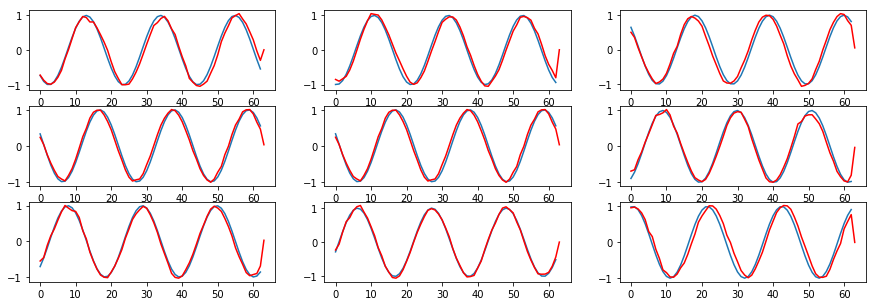

In [7]:
import pylab as plt
N = test_x.shape[0]
idices = np.random.choice(np.arange(N), size=9, replace=False)

result_pred = []
result_true = []

by = mp.flux(trc, [1, seq_len, FEATURE_SIZE], mp.variable, mp.tfloat)
zpad2 = mp.flux(trc, [1, 1, FEATURE_SIZE], mp.variable, mp.tfloat)
mp.fill(zpad2, 0.0)
mp.copyf(zpad, zpad2)
i = 0
for idx in idices:
    sample_x = test_x[idx:idx+1]
    sample_y = test_y[idx:idx+1]
    
    mp.copya(in_d, sample_x)
    mp.copya(tar_d, sample_y)

    mp.fill(by, 0.0)#reset
    mp.howrite(by, in_d)#input
    mp.howrite(by, zpad, half_len)#padding

    #mp.howrite(ytar, tar_d)#target
    #mp.howrite(ytar, zpad, half_len)#end token

    mp.feedf(by_gate, by)
    #mp.feedf(tar_gate, ytar)

    y_preds, loss = mp.predict(cnet, 1)
    
    #if loss is not None:
    #   mp.printo(loss);
    mp.printo(y_preds)
    #print(sample_y)
    #print("-------------------------")
    #ev = mp.eval(y_preds)
    #print(ev)
    #i += 1
    #if i == 2:
    #    break
    
    _y_preds = mp.eval(y_preds)
    _y_preds = _y_preds.reshape(-1, 1)
    result_pred.append(_y_preds)
    result_true.append(sample_y.reshape(-1, 1))
    
fig, plots = plt.subplots(3, 3)
fig.set_figheight(5)
fig.set_figwidth(15)

plots = plots.reshape(-1)
for i, p in enumerate(plots):
    p.plot(result_true[i])
    p.plot(result_pred[i], color='red')